## 0. Introduction

**结论**

1. 实现了基于离散属性和连续属性的朴素贝叶斯分类器
2. 进行了二项检验、t检验、交叉验证t检验、McNemar检验，得出以下结论：
    1. 通过二项检验发现，对于离散属性的朴素贝叶斯分类器，在**99%的置信水平**下，认为模型分**泛化错误率小于42%**
    2. 通过t检验发现，对于离散属性的朴素贝叶斯分类器，在以**90%的置信度**下，认为模型的**泛化错误率等于8%**
    3. 通过交叉验证t检验发现，离散属性的朴素贝叶斯分类器的性能比连续属性的更优（**未考虑到独立采样**）
    4. 通过$5\times 2$折交叉验证t检验发现，两者性能**没有显著差别**
    5. 通过McNemar检验发现，两者性能**没有显著差别**
    

**数据**

    - 2021冬模式识别数据收集.xlsx
   
> 说明:
>
> 以身高、体重、脚长、尺码来判断性别
>
> 以上特征可以视为离散型属性，亦可以视为连续型属性
 
 **优点**：小样本，多分类

**缺点**：对于输入数据敏感

**公式**

$$
P(c|x)=\frac{p(c,x)}{p(x)}=\frac{P(c)p(x|c)}{p(x)}=\frac{P(c)}{p(x)}\prod_{i=1}^{d}{P(x_i|c)}
$$

对于所有类别来说，$P(x)$一样，因此只考虑分子部分

$$
h_{nb}=arg\ max_{c\in \gamma}P(c)\prod_{i=1}^d{P(x_i|c)}
$$

1. 离散
$$
p(c)=\frac{|D_c|}{|D|}
$$

> 拉普拉斯修正 $p(c)=\frac{|D_c|+1}{|D|+N}$


2. 连续

> 假设$p(x_i|c)\sim N(\mu_{c,i},\sigma_{c,i}^2)$

$$
p(x_i|c)=\frac{1}{\sqrt{2\pi}\sigma_{c,i}} exp(-\frac{(x_i-\mu_{c,i})^2}{2\sigma_{c,i}^2})
$$
 
 **环境**
 
 ```shell
 Python                         3.8.4
 matplotlib                     3.5.2
 numpy                          1.22.4
 pandas                         1.3.5
 scikit-learn                   1.1.1
 seaborn                        0.11.2
 ```

## 1. 导入包和模块

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold
from collections import Counter

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题

warnings.filterwarnings('ignore')

In [2]:
def load_data(fileName):
    data = pd.read_excel(fileName,index_col=0)
    data = data.dropna(axis=1)
    data['性别'] = data['性别'].map({'男':0,'女':1})
    # sns.pairplot(data)
    return data

## 2. 离散属性的朴素贝叶斯分类器

In [3]:
# 定义朴素贝叶斯分类器-离散型
class NaiveBayesClassifierDiscrete:
    def __init__(self):
        self.data = None
        self.labels = None
        self.prior_prob = None
        self.conditional_prob = None
        self.num_values = None

    # 训练函数
    def fit(self, data, labels):
        """
        函数说明:
            - 计算先验概率和条件概率        
        parameters:
            - data 训练特征矩阵
            - labels 训练标签向量
        return:
            - self
        """
        self.data = data
        self.labels = labels
        # 计算先验概率
        label_counts = Counter(labels)  # 计算每个标签的数量
        num_samples = len(labels)  # 计算样本总数
        self.prior_prob = {label: count / num_samples for label, count in label_counts.items()}  # 计算每个标签的先验概率

        # 计算条件概率
        self.conditional_prob = {}
        self.num_values = {}
        for label in label_counts.keys():
            self.conditional_prob[label] = {}
            for feature_index in range(len(data[0])):
                self.conditional_prob[label][feature_index] = {}
                label_indexes = np.where(labels == label)[0]
                feature_values = data[label_indexes, feature_index]
                value_counts = Counter(feature_values)  # 统计每个特征值出现的次数
                self.num_values[feature_index] = len(feature_values)  # 该特征值出现的总次数
                # self.conditional_prob[label][feature_index] = {value: count / num_values for value, count in value_counts.items()}  # 计算每个特征值的条件概率
                # 拉普拉斯变换修正
                self.conditional_prob[label][feature_index] = {value: (count+1) / (2 * self.num_values[feature_index]) 
                                                               for value, count in value_counts.items()}  # 计算每个特征值的条件概率
        

    # 预测函数
    def predict(self, data):
        """
        函数说明:
            - 给定特征值，预测类别
        parameters:
            - data 测试特征向量
        return:
            - self
        """
        labels = []
        pre_prob=[]
        for sample in data:
            # 计算每个标签的概率
            label_prob = {label: self.prior_prob[label] for label in self.prior_prob.keys()}
            for label in self.prior_prob.keys():
                for feature_index in range(len(sample)):
                    feature_value = sample[feature_index]
                    if feature_value in self.conditional_prob[label][feature_index].keys():
                        label_prob[label] *= self.conditional_prob[label][feature_index][feature_value]
                    else:
                        # label_prob[label] = 0
                        # 拉普拉斯修正
                        label_prob[label] *= 1 / (2*self.num_values[feature_index])
            pre_prob.append(label_prob)
            # 根据概率选择最大的标签
            labels.append(max(label_prob, key=label_prob.get))
        pre_prob1=[ prob for it in pre_prob for prob in list(it.values())]
        pre_prob1=np.array(pre_prob1).reshape(-1,2)
        
        sumcol=np.sum(pre_prob1,axis=1,keepdims=True)
        pre=pre_prob1/sumcol
        return labels,pre

## 3. 连续属性的朴素贝叶斯分类器

In [4]:
# 定义朴素贝叶斯分类器-连续型
class NaiveBayesClassifierContinuous:
    def __init__(self):
        self.data = None
        self.labels = None
        self.prior_prob = None
        self.conditional_prob = None
        self.num_values = None
        self.mu = None
        self.std = None
    
    def gauss(self, x, mu, std):
        """
        函数说明:
            - 计算高斯函数值
        parameters:
            - mu 均值
            - std 标准差
        return:
            - ans 函数值
        """
        ans = 1/(np.sqrt(2*np.pi)*std)*np.exp(-(x-mu)**2/(2*(std**2)))
        return ans

    # 训练函数
    def fit(self, data, labels):
        """
        函数说明:
            - 计算先验概率和条件概率        
        parameters:
            - data 训练特征矩阵
            - labels 训练标签向量
        return:
            - self
        """
        self.data = data
        self.labels = labels
        # 计算先验概率
        label_counts = Counter(labels)  # 计算每个标签的数量
        num_samples = len(labels)  # 计算样本总数
        self.prior_prob = {label: count / num_samples for label, count in label_counts.items()}  # 计算每个标签的先验概率
        
        # 计算每个标签的第i个特征的均值mu和标准差std
        # 用样本均值和标准差来进行估计
        self.mu = {}; self.std = {}
        for label in label_counts.keys():
            self.mu[label] = {}; self.std[label] = {}
            for feature_index in range(len(data[0])):
                label_indexes = np.where(labels == label)[0]
                feature_values = data[label_indexes, feature_index]
                mu = np.mean(feature_values); std = np.std(feature_values)
                self.mu[label][feature_index] = mu
                self.std[label][feature_index] = std
        
    
        # 计算条件概率
        self.conditional_prob = {}
        self.num_values = {}
        for label in label_counts.keys():
            self.conditional_prob[label] = {}
            for feature_index in range(len(data[0])):
                label_indexes = np.where(labels == label)[0]
                feature_values = data[label_indexes, feature_index]
                self.num_values[feature_index] = len(feature_values)
                value_counts = Counter(feature_values)
                self.conditional_prob[label][feature_index] = {value: self.gauss(value, self.mu[label][feature_index], self.std[label][feature_index]) for value in value_counts.keys()}
        return self
    # 预测函数
    def predict(self, data):
        """
        函数说明:
            - 给定特征值，预测类别
        parameters:
            - data 测试特征向量
        return:
            - self
        """
        labels = []
        pre_prob=[]
        pre_prob2=[]
        for sample in data:
            # 计算每个标签的概率
            label_prob = {label: self.prior_prob[label] for label in self.prior_prob.keys()}
            for label in self.prior_prob.keys():
                for feature_index in range(len(sample)):
                    feature_value = sample[feature_index]
                    # label_prob[label] *= self.conditional_prob[label][feature_index][feature_value]
                    if feature_value in self.conditional_prob[label][feature_index].keys():
                        label_prob[label] *= self.conditional_prob[label][feature_index][feature_value]
                    else:
                        # label_prob[label] = 0
                        # 拉普拉斯修正
                        label_prob[label] *= 1 / (2*self.num_values[feature_index])
            
            pre_prob.append(label_prob)
            
            # 根据概率选择最大的标签
            labels.append(max(label_prob, key=label_prob.get))

        #[prob[0]/(prob[0]+prob[1]),prob[1]/(prob[0]+prob[1])]
        pre_prob1=[ prob for it in pre_prob for prob in list(it.values())]
        pre_prob1=np.array(pre_prob1).reshape(-1,2)

        sumcol=np.sum(pre_prob1,axis=1,keepdims=True)
        pre=pre_prob1/sumcol
        return labels,pre

In [5]:
if __name__ == '__main__' :
    fileName =  r'D:\ipynb\实验数据\genderdata\2021冬模式识别数据收集.xlsx'
    data = load_data(fileName)
    X = data.iloc[:, 1:]
    y = data.iloc[:, 0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=8)
    X_train = X_train.values; X_test = X_test.values
    y_train = y_train.values; y_test = y_test.values
    NBC = NaiveBayesClassifierContinuous()
    NBD = NaiveBayesClassifierDiscrete()
    NBC.data = X_train; NBC.labels = y_train
    NBD.data = X_train; NBD.labels = y_train
    NBC.fit(X_train, y_train); NBD.fit(X_train, y_train)
    y_pred_C,pre_prob_C = NBC.predict(X_test)
    y_pred_D,pre_prob_D = NBD.predict(X_test)
    print('y_pred_C:\t', y_pred_C)
    print('y_pred_D:\t', y_pred_D)
    print('y_test:\t\t', list(y_test))
    print('pre_prob_C',pre_prob_C)
    print('pre_prob_D',pre_prob_D)

y_pred_C:	 [0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
y_pred_D:	 [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]
y_test:		 [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
pre_prob_C [[0.9311844  0.0688156 ]
 [0.32616319 0.67383681]
 [0.95988386 0.04011614]
 [0.8943448  0.1056552 ]
 [0.20990666 0.79009334]
 [0.94434191 0.05565809]
 [0.97184763 0.02815237]
 [0.02416378 0.97583622]
 [0.36309054 0.63690946]
 [0.70131306 0.29868694]
 [0.9209941  0.0790059 ]]
pre_prob_D [[0.96969697 0.03030303]
 [0.18181818 0.81818182]
 [0.94990724 0.05009276]
 [0.97959184 0.02040816]
 [0.12903226 0.87096774]
 [0.97560976 0.02439024]
 [0.94674556 0.05325444]
 [0.47058824 0.52941176]
 [0.66666667 0.33333333]
 [0.27272727 0.72727273]
 [0.96969697 0.03030303]]


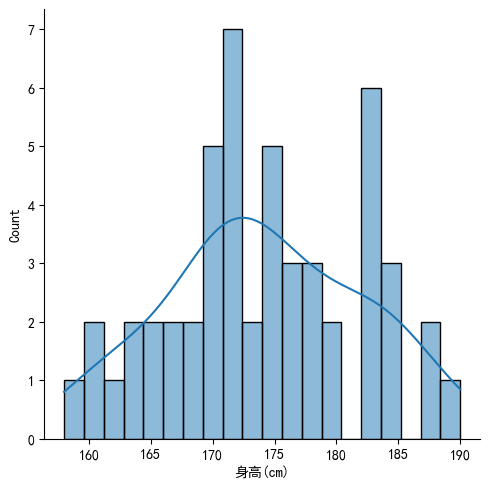

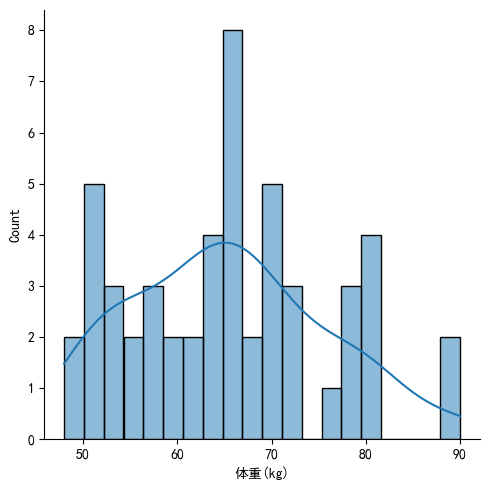

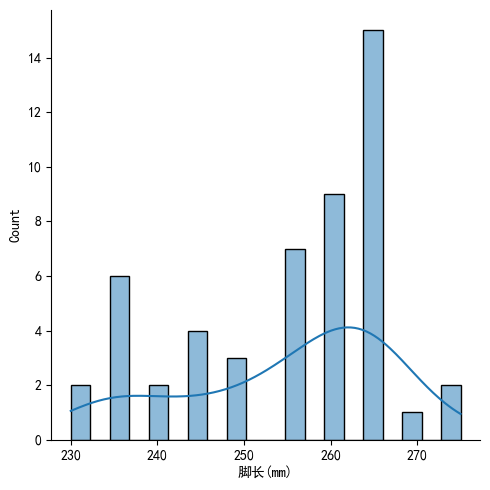

In [6]:
data=data.dropna(axis=1)
height=data['身高(cm)']
weight=data['体重(kg)']
footlength=data['脚长(mm)']
x=len(height)
#sns.kdeplot(height,shade=True)
sns.displot(x=height,bins=20,kde=True)
sns.displot(x=weight,bins=20,kde=True)
sns.displot(x=footlength,bins=20,kde=True)

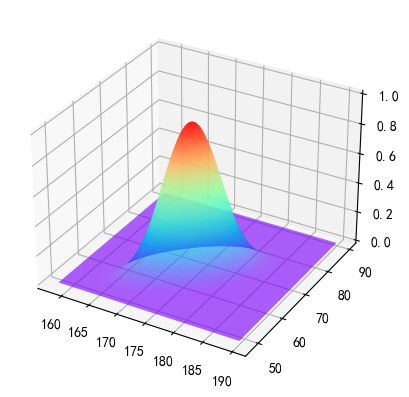

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import math
#matplotlib.use('TkAgg')
height=data['身高(cm)']
weight=data['体重(kg)']
r=data[['身高(cm)', '体重(kg)']].corr(method='pearson')
meanx=np.mean(height)
varx=np.var(height)*len(height)/(len(height)-1)
sigmax=np.sqrt(varx)
meany=np.mean(weight)
vary=np.var(weight)*len(weight)/(len(weight)-1)
sigmay=np.sqrt(vary)
pi=math.pi
fig=plt.figure()
ax=plt.axes(projection='3d')
x = np.arange(start=height.min(), stop=height.max(), step=0.1)
y = np.arange(start=weight.min(), stop=weight.max(), step=0.1)
X, Y = np.meshgrid(x, y)
z=(2*pi*sigmax*sigmay*np.sqrt(1-r.iloc[0][1]**2))**(-1)*np.exp(((X-meanx)**2/varx+(Y-meany)**2/vary-2*r.iloc[0][1]*(X-meanx)*(Y-meany)/sigmax/sigmay)/(-2*(1-r.iloc[0][1])**2))
z=(z-z.min())/(z.max()-z.min())
ax.plot_surface(X,Y,z,alpha=0.9, cstride=1, rstride = 1, cmap='rainbow')
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import sklearn.metrics 
import pandas as pd


def my_confusion_matrix(y_true,y_pred,classes,normalize=False, title=None, cmap=plt.cm.Blues):
   
    y_true=np.array([ 1-y for y in y_true])
    y_pred=np.array([ 1-y for y in y_pred])
    print('y_true,y_score',y_true,y_pred)
    precision = []
    recall = []
    TP=0
    FP=0
    FN=0
    TN=0
    for i in range(len(y_true)) :
        if y_pred[i] == 1:
            if y_true[i] == 1:
                TP+=1
            else :
                FP+=1
        else:
            if y_true[i]==1:
                FN+=1
            else:
                TN+=1
                
    precision.append(TP/(TP+FP))
    recall.append(TP/(TP+FN))
    
    cm = np.array([[TP,FN],[FP,TN]])
    print('cm',cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return 

classes=[0,1]
my_confusion_matrix(y_test,y_pred_D,classes)

y_true,y_score [1 0 1 1 1 1 1 1 1 0 1] [1 0 1 1 0 1 1 0 1 0 1]
cm [[7 2]
 [0 2]]


y_true,y_score [0 1 0 0 0 0 0 0 0 1 0] [0 1 0 0 1 0 0 1 0 1 0]
[[7 2]
 [0 2]]


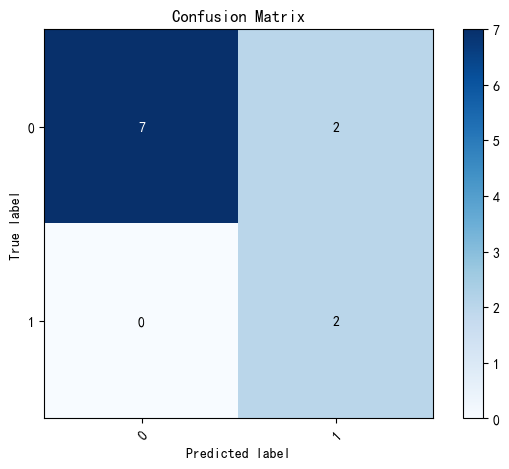

<Figure size 640x480 with 0 Axes>

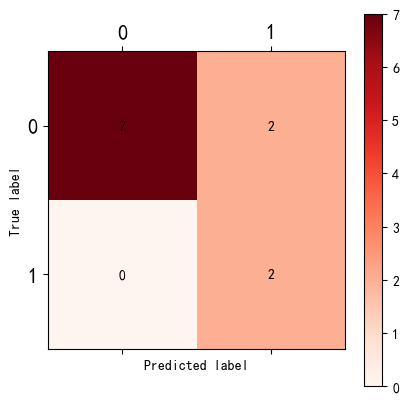

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 对上面进行赋值
y_test=np.array(y_test)
y_pred_D=np.array(y_pred_D)
print('y_true,y_score',y_test,y_pred_D)
C = confusion_matrix(y_true=y_test, y_pred=y_pred_D, labels=[0,1]) # 可将'1'等替换成自己的类别，如'cat'。
print(C)
fig=plt.figure()
plt.matshow(C, cmap=plt.cm.Reds) # 根据最下面的图按自己需求更改颜色
plt.colorbar()

for i in range(len(C)):
    for j in range(len(C)):
        plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')

plt.tick_params(labelsize=15) # 设置左边和上面的label类别如0,1,2,3,4的字体大小。
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.ylabel('True label', fontdict={'family': 'Times New Roman', 'size': 20}) # 设置字体大小。
#plt.xlabel('Predicted label', fontdict={'family': 'Times New Roman', 'size': 20})
#plt.xticks(range(0,5), labels=['a','b','c','d','e']) # 将x轴或y轴坐标，刻度 替换为文字/字符
#plt.yticks(range(0,5), labels=['a','b','c','d','e'])
plt.show()

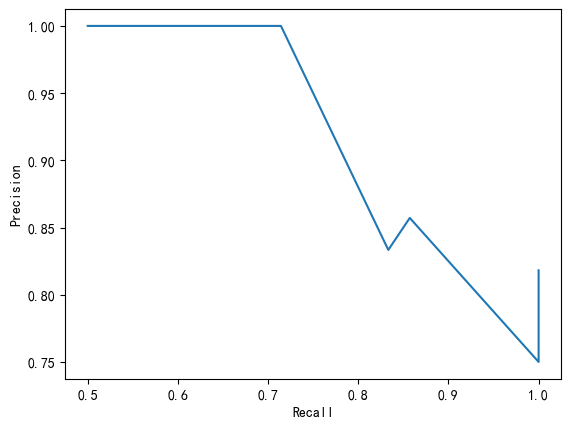

In [10]:
y_true =y_test
y_scores = pre_prob_D
df=pd.DataFrame(np.array([y_true,y_scores[:,0]]).reshape(11,2),index=list(range(0,11)),columns=['真实','预测'])
#df.sort_values(by=['预测'],ascending=False,inplace=True
def my_PR(y_true, y_score):

    y_true=np.array([ 1-y for y in y_true])
    precision = []
    recall = []
    for hold in y_score:
        TP=0
        FP=0
        FN=0
        TN=0
        for i in range(len(y_true)) :
            if y_score[i] >= hold:
                if y_true[i] >= 0.5:
                    TP+=1
                else :
                    FP+=1
            else:
                if y_true[i]<0.5:
                    FN+=1
                else:
                    TN+=1
                    
        precision.append(TP/(TP+FP))
        recall.append(TP/(TP+FN))
    
    PreRe = [(re,pre) for re,pre in zip(recall,precision)]
    PreRe = sorted(PreRe)#默认按第一列进行升序排列
    precision = [pre for _,pre in PreRe]
    recall = [re for re,_ in PreRe]
   
    return precision, recall
    
precision, recall = my_PR(df['真实'], df['预测'])
import matplotlib.pyplot as plt
fig=plt.figure()
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [11]:
def ROC(y_pred,pre_prob):
    #参数1，pred:样本真实标签值
    #参数2，pre_prob:样本被划分为正类的概率Score值
    
    #P=sum(y_true>=0.5)  #计算样本中正例的个数
    #N=sum(y_true<0.5)  #计算样本中反例的个数
    
    P=list(y_pred).count(1)  #计算样本中正例的个数
    N=list(y_pred).count(0)
    
    
    TPR=[];FPR=[];  
    for k in pre_prob:
        TP=0;FP=0;
        test=[];
        #依次将各样本的pre_prob值作为分类阈值threshold，
        #当测试样本属于正样本的概率大于或等于这个threshold时，认为它为正样本，否则为负样本。
        for t in pre_prob:  
            if t>=k:
                test.append(1)
            else:
                test.append(0)
        for i,val in enumerate(y_pred):
            if val==1:
                if test[i]==1:
                    TP+=1
            elif val==0:
                if test[i]==1:
                    FP+=1
        #每次选取一个不同的threshold，得到一组FPR和TPR
        tpr=TP/P
        fpr=FP/N
        TPR.append(tpr)
        FPR.append(fpr)
    #将得到的所有FPR和TPR从低到高排序，便于绘图
    TPR.sort()
    FPR.sort()
    fig=plt.figure()
    #绘制ROC曲线图
    plt.plot(FPR,TPR,color='darkorange',label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return TPR,FPR

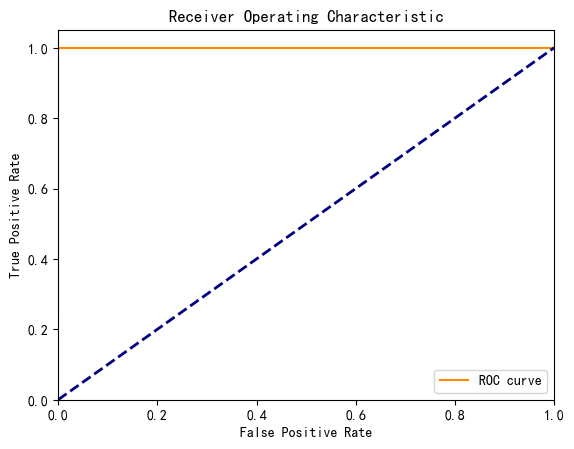

In [12]:
TPR,FPR=ROC(y_pred_D,pre_prob_D[:,1])

roc_auc: 0.8888888888888888


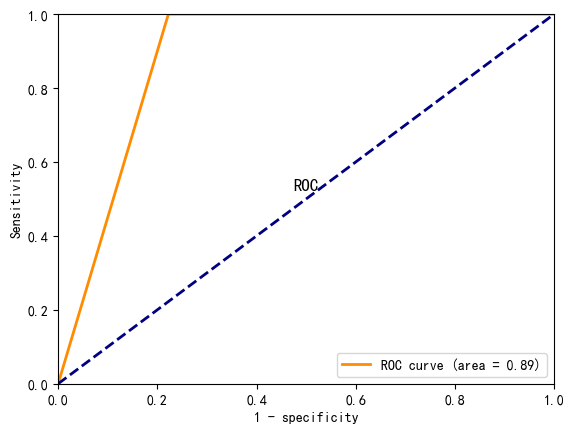

In [13]:
from sklearn.metrics import roc_curve 
from sklearn import metrics
fpr, tpr, threshold = roc_curve(y_test, y_pred_D)
roc_auc = metrics.auc(fpr,tpr)   # 准确率代表所有正确的占所有数据的比值
print('roc_auc:', roc_auc)
lw = 2
plt.subplot(1,1,1)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  # 假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - specificity')
plt.ylabel('Sensitivity')
plt.title('ROC', y=0.5)
plt.legend(loc="lower right")
plt.show()

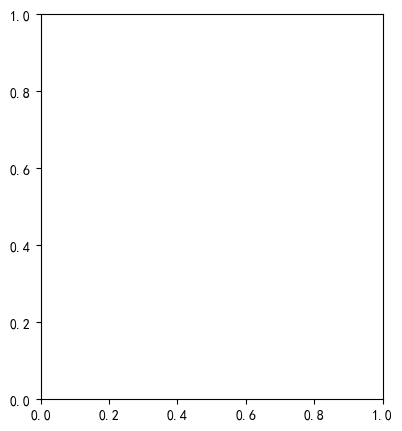

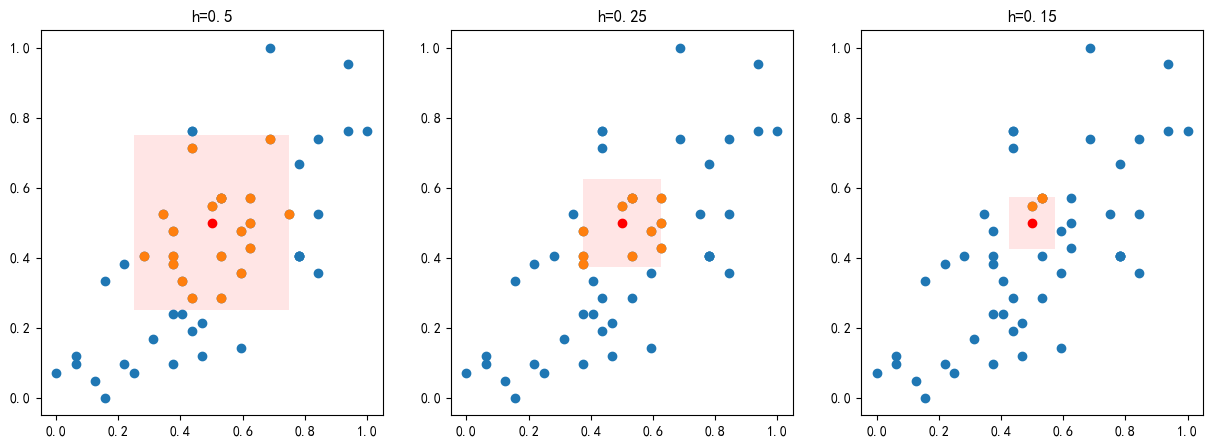

In [ ]:
# -*- coding: utf-8 -*-
"""
@Time ： 2022/3/14 9:50
@Auth ： yusuen
@File ：main.py
@IDE ：PyCharm
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
def generate_data():
    
    datax = data.iloc[:, 1].values
    datax=(datax-datax.min())/(datax.max()-datax.min())
    datay = data.iloc[:, 2].values
    datay=(datay-datay.min())/(datay.max()-datay.min())
    xi = np.array([0.5,0.5])
    x_,y_ = datax,datay
    pos_= np.vstack([datax,datay])
    return x_, y_, pos_

def parzen_window(x, h):

    u = (pos - x.reshape(-1,1))/ h
    ix, iy = pos[:, (abs(u) <= 0.5).all(axis=0)]
    k = len(ix)

    return k / ((h**2) * n)


def rotate(angle):
    ax.view_init(azim=angle)

if __name__ == '__main__':
    n=len(data)
    windowsize = [0.5, 0.25, 0.15]
    xv, yv, pos = generate_data()
    # 散点图
    plt.figure(figsize=(15,5))
    plot_pos = 131
    xi = np.array([0.5,0.5])
    for h in windowsize:
        plt.subplot(plot_pos)
        plot_pos += 1
        u = (pos - xi.reshape(-1, 1)) / h
        ix, iy = pos[:, (abs(u) <= 0.5).all(axis=0)]
        left, bottom, width, height = (0.5-h/2, 0.5-h/2, h, h)
        rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
        plt.gca().add_patch(rect)

        plt.title("h=" + str(h))
        plt.scatter(xv, yv)
        plt.scatter(ix, iy)
        plt.scatter(xi[0], xi[1], c='r')
    plt.show()

    # 三维
    w = 50
    gx = np.linspace(0, 1, w)
    gy = np.linspace(0,1, w)
    # 获得网格坐标矩阵
    gxv, gyv = np.meshgrid(gx, gy)
    fgxv = gxv.ravel()
    fgyv = gyv.ravel()

    for i, h in enumerate(windowsize):
        fpx = np.array([parzen_window(x, h) for x in np.vstack([fgxv,fgyv]).T])
        fpx = fpx.reshape(w, w)
        fig = plt.figure(num = i+1)
        ax = Axes3D(fig)
        surf = ax.plot_surface(gxv,gyv,fpx, rstride=1, cstride=1, cmap='GnBu_r')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('h='+str(h))

        # 添加等高线
        ax.contourf(gxv, gyv, fpx, zdir='z', offset= fpx.max(), cmap='GnBu_r')
        ax.set_zlim3d(0, fpx.max())
        # 添加图例bar
        fig.colorbar(surf, shrink=0.5, aspect=5)
        rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
        rot_animation.save('./rotation_{}.gif'.format('h='+str(h)), dpi=80, writer='pillow')
        plt.show()


## 4. 比较检验

### 4.1. 二项检验

In [ ]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, train_size=0.8, random_state=2)
print(type(X_train0))

In [ ]:
X_train = X_train0.values; X_test = X_test0.values
y_train = y_train0.values; y_test = y_test0.values

In [ ]:
NBD = NaiveBayesClassifierDiscrete()
NBD.fit(X_train, y_train)
y_pred = NBD.predict(X_test)

In [ ]:
errCount = 0
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        errCount += 1
errRate = errCount/len(y_pred)

In [ ]:
errRate

> 假设模型的泛化错误率小于42%，
>
> 即$H_0: \epsilon < 0.42$
>
$$
P(\hat{\epsilon};\epsilon)=C_{m}^n \epsilon^m(1-\epsilon)^n
$$

In [ ]:
m = len(y_pred)

In [ ]:
import math

In [ ]:
P = []
epsilon = 0.42
for n in range(m+1):
    p = math.comb(m, n)*(epsilon**n)*((1-epsilon)**(m-n))
    P.append(p)

In [ ]:
sum(P)

In [ ]:
sns.barplot(list(range(m+1)),P)

> 显著性水平$1-\alpha = 0.99$

In [ ]:
alpha = 0.01
acc = 0
for i in reversed(list(range(m+1))):
    acc += P[i]
    print(acc)
    if acc > alpha:
        print(i)
        break

In [ ]:
errCount

> 落在置信区间内
>
> 以99%的置信水平认为，模型分泛化错误率小于42%

### 4.2. t检验 

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=2)

In [ ]:
NBD = NaiveBayesClassifierDiscrete()
errRate = []
for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    NBD.fit(X_train, y_train)
    y_pred = NBD.predict(X_test)
    errCount = 0
    for i in range(len(y_test)):
        if y_pred[i] != y_test[i]:
            errCount += 1
    errRate.append(errCount/len(y_pred))

In [ ]:
errRate

In [ ]:
mu = np.mean(errRate)
sigma = np.var(errRate, ddof = 1) # 修正

In [ ]:
mu

> $H_0: \epsilon=0.08$
>
> $\alpha = 0.1$

$$
\tau_t = \frac{\sqrt{k}(\mu -\epsilon_0)}{\sigma}
$$
服从自由度为$k-1$的$t$分布
![](https://jaggar-oss.oss-cn-shanghai.aliyuncs.com/img/427a4d0c7f7fdb96f41962d7289fe29.jpg)

In [ ]:
epsilon = 0.08
k = len(y_pred)
t = np.sqrt(k)*(mu - epsilon)/sigma

In [ ]:
t

> 以90%的置信度认为模型的泛化错误率等于8%

### 4.3. 交叉验证t检验

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=2)

In [ ]:
NBD = NaiveBayesClassifierDiscrete()
NBC = NaiveBayesClassifierContinuous()
errRateD = []; errRateC = []
for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    NBD.fit(X_train, y_train); NBC.fit(X_train, y_train)
    y_pred_D = NBD.predict(X_test); y_pred_C = NBC.predict(X_test)
    errCount_D = 0; errCount_C = 0
    for i in range(len(y_test)):
        if y_pred_D[i] != y_test[i]:
            errCount_D += 1
        if y_pred_C[i] != y_test[i]:
            errCount_C += 1
    errRateD.append(errCount_D/len(y_pred))
    errRateC.append(errCount_C/len(y_pred))

> $H_0$: 两模型性能相当
>
> $\alpha=0.1$

$$
\tau_t=|\frac{\sqrt{k}\mu}{\sigma}|
$$
临界值$t_{\alpha/2,k-1}=2.262$

In [ ]:
errRateDelta = np.array(errRateD) - np.array(errRateC)

In [ ]:
k = len(y_pred)
mu = errRateDelta.mean()
sigma = errRateDelta.var(ddof=1)

In [ ]:
t = np.abs(np.sqrt(k)*mu/sigma)

In [ ]:
t

> $t>2.262$ 拒绝原假设

In [ ]:
np.mean(errRateC)

In [ ]:
np.mean(errRateD)

> 两学习器有显著的差别 
>
> 离散型平均错误率较小，认为其性能较优

**采用$5\times 2$折交叉验证**

In [ ]:
NBD = NaiveBayesClassifierDiscrete()
NBC = NaiveBayesClassifierContinuous()
errRateDD = []; errRateCC = []
for i in range(5):
    errRateD = []; errRateC = []
    kf = KFold(n_splits=2, shuffle=True, random_state=i) # 五次随机
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        NBD.fit(X_train, y_train); NBC.fit(X_train, y_train)
        y_pred_D = NBD.predict(X_test); y_pred_C = NBC.predict(X_test)
        errCount_D = 0; errCount_C = 0
        for i in range(len(y_test)):
            if y_pred_D[i] != y_test[i]:
                errCount_D += 1
            if y_pred_C[i] != y_test[i]:
                errCount_C += 1
        errRateD.append(errCount_D/len(y_pred))
        errRateC.append(errCount_C/len(y_pred))
    errRateDD.append(errRateD); errRateCC.append(errRateC)

为了缓解测试错误率的非独立性，仅计算第一次的2折交叉验证的平均值$\mu$，和每次的方差
$$
μ=0.5×(Δ_𝑖^1+Δ_𝑖^2 )\\
σ_𝑖^2=(Δ_𝑖^1−\frac{Δ_𝑖^1+Δ_𝑖^2}{2})^2+(Δ_𝑖^1−\frac{Δ_𝑖^2+Δ_𝑖^2}{2})^2
$$

In [ ]:
errRateDelta = np.array(errRateCC) - np.array(errRateDD)

In [ ]:
errRateDelta

In [ ]:
mu = np.mean(errRateDelta[0])
sigma = np.var(errRateDelta, axis=1, ddof=1)

$$
\tau_t=\frac{\mu}{\sqrt{0.2\sum_{i=1}^{5}\sigma_i^2}}
$$
服从自由度为5的$t$分布，临界值$t_{\alpha/2,5}$

$\alpha=0.1$时，$t_{\alpha/2,5}=2.776$

In [ ]:
t = mu/np.sqrt(0.2*sum(sigma))

In [ ]:
t

> 小于临界值，认为两学习器没有显著差别

### 4.4. McNemar检验

**列联表**
![](https://jaggar-oss.oss-cn-shanghai.aliyuncs.com/img/20221214214255.png)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2)
X_train, X_test = X.values[train_index], X.values[test_index]
y_train, y_test = y.values[train_index], y.values[test_index]

In [ ]:
NBD = NaiveBayesClassifierDiscrete() # 学习器A
NBC = NaiveBayesClassifierContinuous()# 学习器B
errCount_D = 0; errCount_C = 0

NBD.fit(X_train, y_train); NBC.fit(X_train, y_train)
y_pred_D = NBD.predict(X_test); y_pred_C = NBC.predict(X_test)
conTable = np.zeros([2,2])
for i in range(len(y_test)):
    if y_pred_D[i] == 1:
        if y_pred_C[i] == 1:
            conTable[0][0] += 1
        else:
            conTable[1][0] += 1
    else:
        if y_pred_C[i] == 1:
            conTable[0][1] += 1
        else:
            conTable[1][1] += 1

> $H_0: e_{01}=e_{10}$
$$
τ_{χ^2 }=\frac{(𝑏−𝑐)^2}{𝑏+𝑐}
$$
服从自由度为1的卡方分布
>
> $\alpha =0.05$时，临界值为3.8415
>
> $\alpha =0.1$时，临界值为2.7055

In [ ]:
chis = (conTable[0][1] - conTable[1][0])**2/(conTable[0][1] + conTable[1][0])

In [ ]:
chis

> 小于临界值，以95%的置信度认为，两学习器的性能没有显著差别